In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import math
import re
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torcheval.metrics.text import Perplexity

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class TimeMachine(Dataset):
    def __init__(self, path, num_steps, train, num_train=10000, num_test=5000):
        super(TimeMachine, self).__init__()

        corpus, self.vocab = self.build(path)

        array = torch.tensor([corpus[i:i+num_steps+1] for i in range(len(corpus)-num_steps)])
        data, target = array[:, :-1], array[:, 1:]

        if train:
            self.data = data[:num_train]
            self.target = target[:num_train]
        else:
            self.data = data[num_train:num_train+num_test]
            self.target = target[num_train:num_train+num_test]

    def __getitem__(self, index):
        return self.data[index], self.target[index]

    def __len__(self):
        return len(self.data)

    def _get_text(self, path):
        with open(path, 'r') as f:
            text = f.read()
        return text

    def _preprocess(self, raw_text):
        return re.sub('[^A-Za-z]+', ' ', raw_text).lower()[1:]

    def _tokenize(self, text):
        return list(text)

    def _build_vocab(self, text):
        vocab = build_vocab_from_iterator(text, specials=["<unk>"])
        vocab.set_default_index(vocab["<unk>"])
        return vocab

    def build(self, path):
        raw_text = self._get_text(path)
        text = self._preprocess(raw_text)
        tokenized = self._tokenize(text)
        vocab = self._build_vocab(tokenized)
        corpus = [vocab[c] for c in tokenized]
        return corpus, vocab

In [90]:
class RNNLM(nn.Module):
    def __init__(self, vocab_size, num_hiddens):
        super(RNNLM, self).__init__()
        self.vocab_size = vocab_size
        self.rnn = nn.RNN(self.vocab_size, num_hiddens)
        self.fc = nn.Linear(num_hiddens, self.vocab_size)

    def forward(self, inputs):
        embs = F.one_hot(inputs, self.vocab_size).type(torch.float32)
        hiddens, _ = self.rnn(embs)
        outputs = torch.transpose(self.fc(hiddens), 0, 1)
        return outputs

    @torch.no_grad()
    def predict(self, text, num_preds, vocab):
        tokenized = list(re.sub('[^A-Za-z]+', ' ', text).lower())
        corpus = torch.tensor([vocab[c] for c in tokenized]).to(DEVICE)

        embs = F.one_hot(corpus, self.vocab_size).type(torch.float32)
        _, hidden = self.rnn(embs)

        outputs = []
        for i in range(num_preds):
            output = self.fc(hidden)
            output = F.one_hot(output.argmax(), self.vocab_size).type(torch.float32).unsqueeze(0)
            outputs.append(output)
            _, hidden = self.rnn(output, hidden)

        outputs = torch.cat(outputs, dim=0)
        answer = outputs.argmax(dim=1).tolist()
        answer = vocab.lookup_tokens(answer)
        answer = ''.join(answer)

        return text + answer

In [91]:
def check_len(a, n):
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

In [92]:
PATH = '/content/drive/MyDrive/d2l.ai_implementation/datasets/thetimemachine.txt'
BATCH_SIZE = 1024
NUM_HIDDENS = 32
NUM_STEPS = 32
LEARNING_RATE = 1

In [93]:
train_data = TimeMachine(PATH, NUM_STEPS, train=True)
test_data = TimeMachine(PATH, NUM_STEPS, train=False)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [94]:
def train_run_epoch(model, device, train_loader, optimizer, criterion, metric):
    model.train()
    total_loss = 0
    total_ppl = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).t(), target.to(device)

        output = model(data)

        metric.update(output, target)

        output = output.reshape(-1, output.size()[2])
        target = target.flatten()
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_ppl += metric.compute().item()

    avg_loss = total_loss / len(train_loader)
    avg_ppl = total_ppl / len(train_loader)

    return avg_loss, avg_ppl

In [101]:
def test_run_epoch(model, device, test_loader, criterion, metric):
    model.eval()
    total_loss = 0
    total_ppl = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device).t(), target.to(device)

            output = model(data)

            metric.update(output, target)

            output = output.reshape(-1, output.size()[2])
            target = target.flatten()
            loss = criterion(output, target)

            total_loss += loss.item()
            total_ppl += metric.compute().item()

        avg_loss = total_loss / len(test_loader)
        avg_ppl = total_ppl / len(test_loader)

    return avg_loss, avg_ppl

In [96]:
def train(model, device, train_loder, test_loader, optimizer, criterion, metric, num_epochs):
    train_losses = []
    train_ppls = []
    test_losses = []
    test_ppls = []

    for epoch in range(1, num_epochs+1):
        print(f"Epoch [{epoch}/{num_epochs}]")

        train_loss, train_ppl = train_run_epoch(model, device, train_loader, optimizer, criterion, metric)
        train_losses.append(train_loss)
        train_ppls.append(train_ppl)
        print(f"Train Loss = {train_loss:.20f}")
        print(f"Train Perplexity = {train_ppl:.20f}")

        test_loss, test_ppl = test_run_epoch(model, device, test_loader, criterion, metric)
        test_losses.append(test_loss)
        test_ppls.append(test_ppl)
        print(f"Average Test Loss = {test_loss:.20f}")
        print(f"Test Perplexity = {test_ppl:.20f}")
        print()

    return train_losses, train_ppls, test_losses, test_ppls

In [105]:
EPOCHS = 500

model = RNNLM(len(train_data.vocab), NUM_HIDDENS).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
metric = Perplexity().to(DEVICE)

In [106]:
train_losses, train_ppls, test_losses, test_ppls = train(model, DEVICE, train_loader, test_loader, optimizer, criterion, metric, EPOCHS)

Epoch [1/500]
Train Loss = 2.98646395206451398252
Train Perplexity = 22.44240683987426621115
Average Test Loss = 2.89424266815185537993
Test Perplexity = 19.45299422451647686216

Epoch [2/500]
Train Loss = 2.84432597160339373232
Train Perplexity = 18.75374536518242507555
Average Test Loss = 2.80080676078796386719
Test Perplexity = 18.18451216327171593434

Epoch [3/500]
Train Loss = 2.79698879718780535342
Train Perplexity = 17.82042242208088467237
Average Test Loss = 2.74093284606933584868
Test Perplexity = 17.47447578434123016677

Epoch [4/500]
Train Loss = 2.73526918888092041016
Train Perplexity = 17.17756087859930147488
Average Test Loss = 2.67188735008239763857
Test Perplexity = 16.86534224805579640361

Epoch [5/500]
Train Loss = 2.66091346740722656250
Train Perplexity = 16.57606857583123627364
Average Test Loss = 2.58820047378540030181
Test Perplexity = 16.26244280510262640860

Epoch [6/500]
Train Loss = 2.58413264751434335054
Train Perplexity = 15.97058884195909023163
Average Test

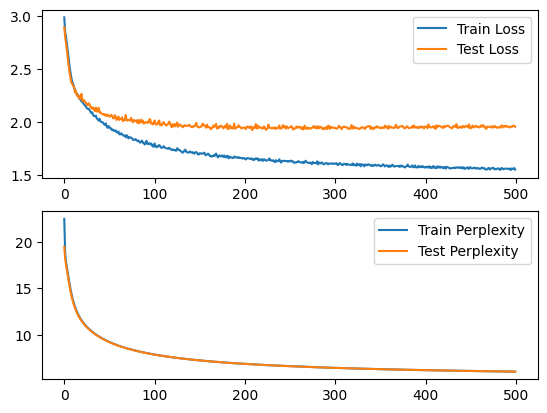

In [119]:
import matplotlib.pyplot as plt

plt.subplot(211)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

plt.subplot(212)
plt.plot(train_ppls, label='Train Perplexity')
plt.plot(test_ppls, label='Test Perplexity')
plt.legend()

plt.show()

In [120]:
model.predict('hello', 30, train_data.vocab)

'hellong and the time traveller and '